<a href="https://colab.research.google.com/github/MyeongQ/2022ML_TP/blob/main/201820807.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Cartoon Character Classification

만화 이미지를 보고 어떤 캐릭터인지를 분류하는 테스크입니다.  
캐릭터 클래스는 총 10개 입니다.

## Download Data
데이터 출처: https://www.kaggle.com/datasets/volkandl/cartoon-classification

코랩에서 캐글 데이터셋을 바로 불러오기 위해서 kaggle.json 파일이 필요합니다.  
```캐글 본인 계정 페이지``` -> ```Account``` -> ```API``` -> ```Create New API Token```
로 kaggle.json 파일을 다운로드 받을 수 있습니다.

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gmk0904","key":"1eb5abe7480de8cbed63627ace254faa"}'}

In [ ]:
ls -1ha kaggle.json # kaggle.json 확인

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d volkandl/cartoon-classification

 29% 3.35G/11.5G [00:13<00:30, 288MB/s]

In [ ]:
!ls # 데이터셋 다운로드 확인

In [ ]:
!unzip cartoon-classification.zip

## Load Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
import torch.utils.data


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        transforms.RandomRotation(5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Normalize(0, 1, inplace=False)
        
    ]),
    "test": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
    ])
}

In [ ]:
# From https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
train_data = ImageFolderWithPaths(root = './cartoon_classification/' + "TRAIN", # load train data
                                   transform = image_transforms["train"], 
                                  )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True) # make train loader

In [ ]:
test_data = ImageFolderWithPaths(root = './cartoon_classification/' + "TEST",
                                   transform = image_transforms["test"] # load test data
                                  )
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False ) # make test loader 
# shuffle false 로 하지 않으면 서버에서 테스트 할 때 문제 생김

In [ ]:
classes = train_data.class_to_idx # class name
classes

{'Familyguy': 0,
 'Gumball': 1,
 'Tsubasa': 2,
 'adventure_time': 3,
 'catdog': 4,
 'pokemon': 5,
 'smurfs': 6,
 'southpark': 7,
 'spongebob': 8,
 'tom_and_jerry': 9}

## Show Example Data

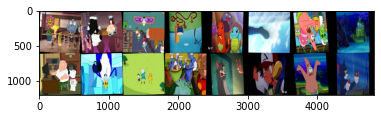

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels, paths = dataiter.next()

batch_size = 64

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()
labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

## Define a Convolutional Neural Network

Modified https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3) # in_channel, out_channel, kernel size
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2, 1)
        self.fc1 = nn.Linear(32 * 73 * 73, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available

In [ ]:
net = Net() # define the network
net = net.to(device) # send the network to the device

In [ ]:
torch.cuda.empty_cache()

## Define a Loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(net.parameters(), lr=0.0005) # 67%

## Train the Network

In [ ]:
for epoch in range(8):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, paths = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training') # colab pro+ 기준, 한 epoch 당 35분 소요

  0%|          | 0/7477 [00:00<?, ?it/s]

[1,   100] loss: 0.081
[1,   200] loss: 0.052
[1,   300] loss: 0.035
[1,   400] loss: 0.024
[1,   500] loss: 0.021
[1,   600] loss: 0.017
[1,   700] loss: 0.012
[1,   800] loss: 0.013
[1,   900] loss: 0.009
[1,  1000] loss: 0.011
[1,  1100] loss: 0.010
[1,  1200] loss: 0.010
[1,  1300] loss: 0.010
[1,  1400] loss: 0.007
[1,  1500] loss: 0.006
[1,  1600] loss: 0.007
[1,  1700] loss: 0.008
[1,  1800] loss: 0.007
[1,  1900] loss: 0.007
[1,  2000] loss: 0.006
[1,  2100] loss: 0.006
[1,  2200] loss: 0.005
[1,  2300] loss: 0.006
[1,  2400] loss: 0.005
[1,  2500] loss: 0.006
[1,  2600] loss: 0.007
[1,  2700] loss: 0.005
[1,  2800] loss: 0.005
[1,  2900] loss: 0.004
[1,  3000] loss: 0.006
[1,  3100] loss: 0.006
[1,  3200] loss: 0.003
[1,  3300] loss: 0.006
[1,  3400] loss: 0.003
[1,  3500] loss: 0.004
[1,  3600] loss: 0.004
[1,  3700] loss: 0.002
[1,  3800] loss: 0.004
[1,  3900] loss: 0.003
[1,  4000] loss: 0.004
[1,  4100] loss: 0.005
[1,  4200] loss: 0.005
[1,  4300] loss: 0.004
[1,  4400] 

  0%|          | 0/7477 [00:00<?, ?it/s]

[2,   100] loss: 0.002
[2,   200] loss: 0.004
[2,   300] loss: 0.004
[2,   400] loss: 0.005
[2,   500] loss: 0.006
[2,   600] loss: 0.003
[2,   700] loss: 0.002
[2,   800] loss: 0.004
[2,   900] loss: 0.002
[2,  1000] loss: 0.001
[2,  1100] loss: 0.001
[2,  1200] loss: 0.001
[2,  1300] loss: 0.003
[2,  1400] loss: 0.002
[2,  1500] loss: 0.002
[2,  1600] loss: 0.001
[2,  1700] loss: 0.003
[2,  1800] loss: 0.003
[2,  1900] loss: 0.002
[2,  2000] loss: 0.005
[2,  2100] loss: 0.002
[2,  2200] loss: 0.002
[2,  2300] loss: 0.002
[2,  2400] loss: 0.003
[2,  2500] loss: 0.002
[2,  2600] loss: 0.001
[2,  2700] loss: 0.002
[2,  2800] loss: 0.001
[2,  2900] loss: 0.004
[2,  3000] loss: 0.003
[2,  3100] loss: 0.003
[2,  3200] loss: 0.002
[2,  3300] loss: 0.002
[2,  3400] loss: 0.003
[2,  3500] loss: 0.002
[2,  3600] loss: 0.002
[2,  3700] loss: 0.002
[2,  3800] loss: 0.001
[2,  3900] loss: 0.001
[2,  4000] loss: 0.004
[2,  4100] loss: 0.004
[2,  4200] loss: 0.001
[2,  4300] loss: 0.001
[2,  4400] 

  0%|          | 0/7477 [00:00<?, ?it/s]

[3,   100] loss: 0.001
[3,   200] loss: 0.002
[3,   300] loss: 0.001
[3,   400] loss: 0.001
[3,   500] loss: 0.001
[3,   600] loss: 0.003
[3,   700] loss: 0.002
[3,   800] loss: 0.002
[3,   900] loss: 0.003
[3,  1000] loss: 0.002
[3,  1100] loss: 0.004
[3,  1200] loss: 0.003
[3,  1300] loss: 0.003
[3,  1400] loss: 0.004
[3,  1500] loss: 0.002
[3,  1600] loss: 0.001
[3,  1700] loss: 0.001
[3,  1800] loss: 0.002
[3,  1900] loss: 0.001
[3,  2000] loss: 0.001
[3,  2100] loss: 0.003
[3,  2200] loss: 0.004
[3,  2300] loss: 0.002
[3,  2400] loss: 0.002
[3,  2500] loss: 0.001
[3,  2600] loss: 0.001
[3,  2700] loss: 0.001
[3,  2800] loss: 0.001
[3,  2900] loss: 0.004
[3,  3000] loss: 0.004
[3,  3100] loss: 0.001
[3,  3200] loss: 0.001
[3,  3300] loss: 0.002
[3,  3400] loss: 0.001
[3,  3500] loss: 0.001
[3,  3600] loss: 0.000
[3,  3700] loss: 0.001
[3,  3800] loss: 0.001
[3,  3900] loss: 0.002
[3,  4000] loss: 0.002
[3,  4100] loss: 0.001
[3,  4200] loss: 0.003
[3,  4300] loss: 0.003
[3,  4400] 

  0%|          | 0/7477 [00:00<?, ?it/s]

[4,   100] loss: 0.000
[4,   200] loss: 0.002
[4,   300] loss: 0.003
[4,   400] loss: 0.001
[4,   500] loss: 0.001
[4,   600] loss: 0.002
[4,   700] loss: 0.001
[4,   800] loss: 0.001
[4,   900] loss: 0.003
[4,  1000] loss: 0.002
[4,  1100] loss: 0.001
[4,  1200] loss: 0.001
[4,  1300] loss: 0.000
[4,  1400] loss: 0.001
[4,  1500] loss: 0.001
[4,  1600] loss: 0.001
[4,  1700] loss: 0.002
[4,  1800] loss: 0.002
[4,  1900] loss: 0.002
[4,  2000] loss: 0.000
[4,  2100] loss: 0.000
[4,  2200] loss: 0.003
[4,  2300] loss: 0.002
[4,  2400] loss: 0.001
[4,  2500] loss: 0.004
[4,  2600] loss: 0.003
[4,  2700] loss: 0.002
[4,  2800] loss: 0.001
[4,  2900] loss: 0.002
[4,  3000] loss: 0.000
[4,  3100] loss: 0.001
[4,  3200] loss: 0.001
[4,  3300] loss: 0.002
[4,  3400] loss: 0.003
[4,  3500] loss: 0.002
[4,  3600] loss: 0.004
[4,  3700] loss: 0.003
[4,  3800] loss: 0.001
[4,  3900] loss: 0.001
[4,  4000] loss: 0.001
[4,  4100] loss: 0.002
[4,  4200] loss: 0.004
[4,  4300] loss: 0.003
[4,  4400] 

  0%|          | 0/7477 [00:00<?, ?it/s]

[5,   100] loss: 0.002
[5,   200] loss: 0.002
[5,   300] loss: 0.000
[5,   400] loss: 0.000
[5,   500] loss: 0.001
[5,   600] loss: 0.001
[5,   700] loss: 0.001
[5,   800] loss: 0.001
[5,   900] loss: 0.001
[5,  1000] loss: 0.002
[5,  1100] loss: 0.001
[5,  1200] loss: 0.001
[5,  1300] loss: 0.001
[5,  1400] loss: 0.001
[5,  1500] loss: 0.000
[5,  1600] loss: 0.000
[5,  1700] loss: 0.000
[5,  1800] loss: 0.007
[5,  1900] loss: 0.003
[5,  2000] loss: 0.005
[5,  2100] loss: 0.002
[5,  2200] loss: 0.003
[5,  2300] loss: 0.002
[5,  2400] loss: 0.000
[5,  2500] loss: 0.001
[5,  2600] loss: 0.001
[5,  2700] loss: 0.003
[5,  2800] loss: 0.001
[5,  2900] loss: 0.001
[5,  3000] loss: 0.001
[5,  3100] loss: 0.000
[5,  3200] loss: 0.002
[5,  3300] loss: 0.001
[5,  3400] loss: 0.001
[5,  3500] loss: 0.004
[5,  3600] loss: 0.003
[5,  3700] loss: 0.001
[5,  3800] loss: 0.001
[5,  3900] loss: 0.002
[5,  4000] loss: 0.001
[5,  4100] loss: 0.001
[5,  4200] loss: 0.001
[5,  4300] loss: 0.000
[5,  4400] 

  0%|          | 0/7477 [00:00<?, ?it/s]

[6,   100] loss: 0.001
[6,   200] loss: 0.002
[6,   300] loss: 0.002
[6,   400] loss: 0.002
[6,   500] loss: 0.002
[6,   600] loss: 0.000
[6,   700] loss: 0.001
[6,   800] loss: 0.004
[6,   900] loss: 0.003
[6,  1000] loss: 0.001
[6,  1100] loss: 0.004
[6,  1200] loss: 0.003
[6,  1300] loss: 0.000
[6,  1400] loss: 0.002
[6,  1500] loss: 0.001
[6,  1600] loss: 0.001
[6,  1700] loss: 0.000
[6,  1800] loss: 0.001
[6,  1900] loss: 0.002
[6,  2000] loss: 0.001
[6,  2100] loss: 0.001
[6,  2200] loss: 0.001
[6,  2300] loss: 0.000
[6,  2400] loss: 0.000
[6,  2500] loss: 0.001
[6,  2600] loss: 0.003
[6,  2700] loss: 0.001
[6,  2800] loss: 0.001
[6,  2900] loss: 0.001
[6,  3000] loss: 0.001
[6,  3100] loss: 0.005
[6,  3200] loss: 0.001
[6,  3300] loss: 0.001
[6,  3400] loss: 0.003
[6,  3500] loss: 0.001
[6,  3600] loss: 0.003
[6,  3700] loss: 0.005
[6,  3800] loss: 0.001
[6,  3900] loss: 0.000
[6,  4000] loss: 0.001
[6,  4100] loss: 0.001
[6,  4200] loss: 0.001
[6,  4300] loss: 0.000
[6,  4400] 

  0%|          | 0/7477 [00:00<?, ?it/s]

[7,   100] loss: 0.001


KeyboardInterrupt: ignored

In [ ]:
import gc
gc.collect()

8180

## Save the Network

In [ ]:
# save the trained model
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

## Load the Network

In [ ]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

## Testing & Making a Submission File

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

image_id = []
predicted_label = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader,0)):
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        image_id.append(paths)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {100 * correct // total} %')

  0%|          | 0/18110 [00:00<?, ?it/s]

Accuracy of the network on the 18110 test images: 74 %


In [ ]:
submit_sol = pd.DataFrame(list(zip(image_id, predicted_label)), columns=['id','predicted'])

In [ ]:
submit_sol

,id,predicted
0,(./cartoon_classification/TEST/Familyguy/famil...,0
1,(./cartoon_classification/TEST/Familyguy/famil...,0
2,(./cartoon_classification/TEST/Familyguy/famil...,0
3,(./cartoon_classification/TEST/Familyguy/famil...,0
4,(./cartoon_classification/TEST/Familyguy/famil...,0
...,...,...
18105,(./cartoon_classification/TEST/tom_and_jerry/T...,9
18106,(./cartoon_classification/TEST/tom_and_jerry/T...,9
18107,(./cartoon_classification/TEST/tom_and_jerry/T...,9
18108,(./cartoon_classification/TEST/tom_and_jerry/T...,9


In [ ]:
import os

def clean_path(path):
  cleaned_path = os.path.normpath(path)
  cleaned_path = path.split(os.sep)
  new_path = cleaned_path[3] +'/' + cleaned_path[4] # cartoon name/xx.jpg
  return new_path

In [ ]:
ls

cartoon_classification/     kaggle.json  sample_data/
cartoon-classification.zip  net.pth


In [ ]:
path_list = []
for i in range(len(submit_sol)):
  out = clean_path(submit_sol.iloc[i][0][0])
  path_list.append(out)

submit_sol['id'] = path_list

In [ ]:
submit_sol.to_csv('test_result.csv', index=False)  # submit this test_result.csv to kaggle server